# **추천시스템**
## **sklearn의 surprise 모듈을 사용**
웹을 위한 머신러닝을 surprise로 구현

<br>
## **1 추천시스템의 이해**
Item이 많고, Query를 잘 모를때 유용하다
1. Popularity, High Rated Based (가장단순) : 높은 평점의 item을 추천, 결과값이 동일한 단점이 있다
1. Collaborative Filtering (중간) : user & item의 rating을 이용하여, 사용자/item 유사도를 찾는다
    1. 즉, 해당 user가 해당 item을 얼마나 좋아할 것인지 수치적으로 예측하는 것으로 User-based CF, Item-based CF라고도 함
    1. Similarity 계산은 Euclidean distance, cosine, pearson 등 여러 수학적 유사도를 측정하여, 평점을 weighted sum으로 계산하여 평점을 예측
    1. Personalization (개인화)는 각 개인의 성향에 맞는 item을 추천

<br>
## **2 간단한 추천시스템의 구현**
### **1) Popularity, High Rated Based**

In [1]:
ratings={ 'Dave'  : {'달콤한인생':5,'범죄도시':3,'샤인':3},
          'David' : {'달콤한인생':5,'범죄도시':1,'샤인':4},
          'Alex'  : {'달콤한인생':0,'범죄도시':4,'샤인':5},
          'Andy'  : {'달콤한인생':2,'범죄도시':1,'샤인':5} }

In [3]:
# 가장 평점이 높은 순서로 추천한다
movie_dict = dict()
for rating in ratings:
    for movie in ratings[rating].keys():
        if movie not in movie_dict:
            movie_dict[movie] = ratings[rating][movie]
        else:
            movie_dict[movie] = (movie_dict[movie] + ratings[rating][movie])

for movie in ratings[rating].keys():
    movie_dict[movie] = movie_dict[movie] / len(ratings)

import operator
sorted_x = sorted(movie_dict.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_x[:2])

[('샤인', 4.25), ('달콤한인생', 3.0)]


<br>
### **2) Collaborative Filtering**
1. 사용자/아이템 - 항목 선호도(평점) 행렬을 사용하여 사용자/아이템들 간의 유사도를 계산한다.
1. 사용자/아이템 간의 모든 항목에 대해 예측 값을 계산하고, 상위 N개의 추천 목록을 생성한다.

In [3]:
# 'Alex'와 다른 사용가간의 '범죄도시'와 '샤인'유사도 측정 
# 피타고라스 정리로 유사도 측정
import math
def sim(i, j):
    return math.sqrt(pow(i,2)+pow(j,2))

for i in ratings:
    if i != 'Alex':
        num1 = ratings.get('Alex').get('범죄도시') - ratings.get(i).get('범죄도시')
        num2 = ratings.get('Alex').get('샤인') - ratings.get(i).get('샤인')
        print(i," : ", sim(num1,num2))

Dave  :  2.23606797749979
David  :  3.1622776601683795
Andy  :  3.0


In [4]:
# 'Alex'의 유사도 측정 결과값을 0~1로 정규화
for i in ratings:
    if i != 'Alex':
        num1 = ratings.get('Alex').get('범죄도시') - ratings.get(i).get('범죄도시')
        num2 = ratings.get('Alex').get('샤인') - ratings.get(i).get('샤인')
        print(i," : ", 1 / ( 1 + sim(num1,num2) ) )

Dave  :  0.3090169943749474
David  :  0.2402530733520421
Andy  :  0.25


In [5]:
# 'Dave'의 유사도 측정 결과값을 0~1로 정규화
for i in ratings:
    if i != 'Dave':
        num1 = ratings.get('Dave').get('범죄도시') - ratings.get(i).get('범죄도시')
        num2 = ratings.get('Dave').get('샤인') - ratings.get(i).get('샤인')
        print(i," : ", 1 / ( 1 + sim(num1,num2) ) )

David  :  0.3090169943749474
Alex  :  0.3090169943749474
Andy  :  0.2612038749637414


<br>
## **3 유사도(Similarity) 측정**
### **1) Mean Squared Difference Similarity (평균제곱을 활용)**
User-based Collaborative Filter ,Item-based Collaborative Filter
$$ msd (u(사용자1)와  v(사용자2)간의 거리) = \frac{(u 와 v 평가상품의 평점차의 제곱)}{(u와 v 평가상품의 수)} $$
$$ msd\_sim (유사도) = \frac{1}{msd(u,v) + 1} $$

In [6]:
# 1 Mean Squared Difference Similarity
# Mean Squared Difference (msd) 의 역수를 계산하여 차이가 클 수록 Similarity 값은 작아진다!
# MSD가 0이 되는 경우를 대응하기 위해 1을 무조건 더해준다

def sim_msd(data, name1, name2):
    sum = 0
    count = 0
    for movies in data[name1]:
        if movies in data[name2]: #같은 영화를 봤다면
            sum += pow(data[name1][movies] - data[name2][movies], 2)
            count += 1

    sim_msd = 1 / ( 1 + (sum / count) )
    return round(sim_msd, 4)

sim_msd(ratings, 'Dave','Alex')

0.0909

<br>
### **2) Cosine Similarity (코사인 유사도)**
1. Cosine Similarity에서 **"−1은"** 완전히 반대, **"0은"** 서로 독립, **"1은"** 완전히 같은 경우를 의미
1. 두 벡터간의 유사도를 cosine으로 계산한다
1. u(사용자1) 과 v(사용자2)간의 유사도 측정시 **모든 상품 평점의 기하평균값**으로 계산한다
$$ u \bullet v = |u| \bullet |v| \cos \theta  \ggg  \cos \theta = \frac {u \bullet v}{|u| \bullet |v|} $$
$$ \cos 유사도 = \frac {u \bullet v}{|u| \bullet |v|} $$


In [7]:
import math
def sim_cosine(data, name1, name2):
    sum_name1, sum_name2, sum_name1_name2, count = 0,0,0,0
    for movies in data[name1]:
        if movies in data[name2]: #같은 영화를 봤다면
            sum_name1 += pow(data[name1][movies], 2)
            sum_name2 += pow(data[name2][movies], 2)
            sum_name1_name2 += data[name1][movies] * data[name2][movies]
    sim_cosine = sum_name1_name2 / (math.sqrt(sum_name1) * math.sqrt(sum_name2))
    return round(sim_cosine, 4)

# Dave','Alex' 간의 cosine 유사도
sim_cosine(ratings, 'Dave','Alex')

0.643

<br>
### **3)Pearson Similarity (피어슨 유사도)**
두 벡터의 상관계수(Pearson correlation coefficient)로써 **유사도가 가장 높을 경우 값이 1, *가장 낮을 경우 -1의 값**을 갖는다

In [8]:
def sim_pearson(data, name1, name2):
    avg_name1, avg_name2 ,count = 0, 0, 0
    for movies in data[name1]:
        if movies in data[name2]: #같은 영화를 봤다면
            avg_name1 = data[name1][movies]
            avg_name2 = data[name2][movies]
            count += 1

    avg_name1 = avg_name1 / count
    avg_name2 = avg_name2 / count

    sum_name1, sum_name2, sum_name1_name2, count = 0,0,0,0
    for movies in data[name1]:
        if movies in data[name2]: #같은 영화를 봤다면
            sum_name1 += pow(data[name1][movies] - avg_name1, 2)
            sum_name2 += pow(data[name2][movies] - avg_name2, 2)
            sum_name1_name2 += (data[name1][movies] - avg_name1) * (data[name2][movies] - avg_name2)

    sim_pearson = sum_name1_name2 / (math.sqrt(sum_name1)*math.sqrt(sum_name2))
    return round(sim_pearson, 4)

sim_pearson(ratings, 'Dave','Alex')

0.2166

<br>
### **4) 전체 유사도 측정**
top_match

In [9]:
def top_match(data, name, index=3, sim_function=sim_pearson):
    li=[]
    for i in data: #딕셔너리를 돌고
        if name!=i: #자기 자신이 아닐때만
            li.append((sim_function(data,name,i),i)) #sim_function()을 통해 상관계수를 구하고 li[]에 추가
    li.sort() #오름차순
    li.reverse() #내림차순
    return li[:index]

top_match(ratings, 'Dave', 3)

[(0.8681, 'David'), (0.3984, 'Andy'), (0.2166, 'Alex')]

In [10]:
print('sim_msd \n {} \nsim_cosine \n {}\nsim_pearson \n{}'.format(
    top_match(ratings, 'Dave', 3, sim_function=sim_msd),
    top_match(ratings, 'Dave', 3, sim_function=sim_cosine),
    top_match(ratings, 'Dave', 3, sim_function=sim_pearson)))

sim_msd 
 [(0.375, 'David'), (0.15, 'Andy'), (0.0909, 'Alex')] 
sim_cosine 
 [(0.9412, 'David'), (0.7796, 'Andy'), (0.643, 'Alex')]
sim_pearson 
[(0.8681, 'David'), (0.3984, 'Andy'), (0.2166, 'Alex')]


<br>
## **4 KNN을 활용한 예측값 및 유사도(Similarity) 측정**
### **1) K Nearest Neighbors(KNN) 가중치 예측 기법**
User-based Collaborative Filter ,Item-based Collaborative Filter
$$ msd (u(사용자1)와  v(사용자2)간의 거리) = \frac{(u 와 v 평가상품의 평점차의 제곱)}{(u와 v 평가상품의 수)} $$
$$ msd\_sim (유사도) = \frac{1}{msd(u,v) + 1} $$

In [11]:
ratings_expand = {
    '마동석': {'택시운전사': 3.5,'남한산성': 1.5,'킹스맨:골든서클': 3.0,'범죄도시': 3.5,'아이 캔 스피크': 2.5,'꾼': 3.0,},
    '이정재': {'택시운전사': 5.0,'남한산성': 4.5,'킹스맨:골든서클': 0.5,'범죄도시': 1.5,'아이 캔 스피크': 4.5,'꾼': 5.0,},
    '윤계상': {'택시운전사': 3.0,'남한산성': 2.5,'킹스맨:골든서클': 1.5,'범죄도시': 3.0,'아이 캔 스피크': 3.5,'꾼': 3.0,},
    '설경구': {'택시운전사': 2.5,'남한산성': 3.0,'범죄도시': 4.5,'꾼': 4.0,},
    '최홍만': {'남한산성': 4.5,'킹스맨:골든서클': 3.0,'꾼': 4.5,'범죄도시': 3.0,'아이 캔 스피크': 2.5,},
    '홍수환': {'택시운전사': 3.0,'남한산성': 4.0,'킹스맨:골든서클': 1.0,'범죄도시': 3.0,'꾼': 3.5,'아이 캔 스피크': 2.0,},
    '나원탁': {'택시운전사': 3.0,'남한산성': 4.0,'꾼': 3.0,'범죄도시': 5.0,'아이 캔 스피크': 3.5,},
    '소이현': {'남한산성': 4.5,'아이 캔 스피크': 1.0,'범죄도시': 4.0} }

In [12]:
# KNN With Means : 평점들을 평균값 기준으로 가중 평균한다.
for name in ratings_expand:
    sum = 0
    count = 0
    for movies in ratings_expand[name]:
        sum += ratings_expand[name][movies]
        count += 1
    ratings_expand[name]['avg'] = sum / count
    
# ratings_expand

In [13]:
# KNN을 활용한 추천시스템
def getRecommendation (data, person, k=3, sim_function=sim_pearson):
    result = top_match(data, person, k)
    # score : 평점합, li : 리턴값, score_dic : 유사도 총합, sim_dic : 평점총합
    score, li, score_dic, sim_dic = 0, list(), dict(), dict() 
    for sim, name in result:                     # 튜플이므로 한번에
        print(sim, name)
        if sim < 0 : continue                    # 유사도가 양수인 사람만 추출

        for movie in data[name]: 
            if movie not in data[person]:        # name이 평가를 내리지 않은 영화
                score += sim * data[name][movie] # 그사람의 영화평점 * 유사도
                score_dic.setdefault(movie, 0)   # 기본값 설정
                score_dic[movie] += score        # 합계
                sim_dic.setdefault(movie, 0)     # 조건에 맞는 유사도의 누적합
                sim_dic[movie] += sim
            score = 0                            # 다른 영화 측정을 위해서 값을 초기화

    for key in score_dic: 
        score_dic[key] = score_dic[key] / sim_dic[key] # 평점 총합/ 유사도 총합
        li.append((score_dic[key],key))                # list((tuple))의 리턴을 위해서.

    li.sort()                                          # 오름차순
    li.reverse()                                       # 내림차순
    return li

In [14]:
# '소이현'과 유사한 사용자는?
getRecommendation(ratings_expand, '소이현')

0.9662 홍수환
0.9438 최홍만
0.9438 설경구


[(3.9960754082276266, '꾼'),
 (2.7529319371727747, '택시운전사'),
 (1.9882722513089006, '킹스맨:골든서클')]

In [15]:
# '최홍만' 과 가장 유사한 사용자는?
# 단 유사도 함수는sim_cosine, k는 2를 사용 
getRecommendation(ratings_expand, '최홍만', k=3, sim_function=sim_cosine)

0.9652 홍수환
0.9438 소이현
0.9351 설경구


[(2.753959901068252, '택시운전사')]

<br>
## **5 Latent Factor 모형 (PCA와 Latent Factor 모형)**
1. 복잡한 사용자/영화 특성을 몇 개의 벡터로 간략화 모형을 만든다
1. 다차원 공간의 점들을, **특징 축 (선형변환 : 크기만 다르고 정보(:분산값)는 동일한 축)** 과 **이를 직교하는 축** 으로 요약한다
1. PCA는 차원을 축소한 공간에 정의된 어떤 축에 투영하여 표현

<img src="https://www.researchgate.net/profile/Zheng_Li106/publication/321763710/figure/fig3/AS:583861561995265@1516214852991/Three-dimensional-PCA-score-plot-of-14-liquor-samples-4-ethanol-controls-and-the.ppm" width="500" align='left'>

In [16]:
import numpy as np
from numpy import linalg as la

# 선형변환 : 변수(행)별 평균을 0으로 centering한 행렬 X′를 만든다
# (좌표계의 원점이 평균 벡터와 일치하도록 만듬)
user, item = 5, 3
X = np.random.rand(user, item)  # Data 생성
X -= np.mean(X, axis=0)         # 변수들의 중심을 원점으로 이동한다 
X

array([[ 0.1500986 ,  0.27260069,  0.09153238],
       [-0.53191014, -0.14219272, -0.27163644],
       [ 0.27104461, -0.04899669,  0.05350619],
       [ 0.00954404,  0.23793435, -0.32667877],
       [ 0.10122289, -0.31934563,  0.45327663]])

In [17]:
# 공분산행렬(C)을 기반으로 고유값 { l : eigen_value } 과 고유벡터 { principal_axes: eigen_vector } 계산
C                 = np.cov(X, rowvar = False)
l, principal_axes = la.eig(C)
idx               = l.argsort()[::-1]
l, principal_axes = l[idx], principal_axes[:, idx]
print("""eigen_value : \n{} \n
       \neigen_vector : \n{} 
       \neigen_vector("고유값중 가장 큰 d개의 고유벡터 선택"):\n{}""".format(\
       l, principal_axes, principal_axes[:, :2]))

eigen_value : 
[0.1555437  0.09398771 0.01096646] 

       
eigen_vector : 
[[-0.62932161 -0.59193358  0.5035563 ]
 [ 0.20461688 -0.75130102 -0.62743822]
 [-0.74972411  0.29182431 -0.59392957]] 
       
eigen_vector("고유값중 가장 큰 d개의 고유벡터 선택"):
[[-0.62932161 -0.59193358]
 [ 0.20461688 -0.75130102]
 [-0.74972411  0.29182431]]


In [18]:
# 특징벡터 추출
principal_components = X.dot(principal_axes)
principal_components_short = X.dot(principal_axes[:, :2])
print("특징벡터 :\n {}\n\n특징벡터(요약) :\n{}\n".format(principal_components, principal_components_short))

특징벡터 :
 [[-0.10730562 -0.2669422  -0.14982078]
 [ 0.50929991  0.34241488 -0.01729664]
 [-0.22071466 -0.10801473  0.13544971]
 [ 0.28759806 -0.27974256  0.04954103]
 [-0.46887768  0.31228461 -0.01787331]]

특징벡터(요약) :
[[-0.10730562 -0.2669422 ]
 [ 0.50929991  0.34241488]
 [-0.22071466 -0.10801473]
 [ 0.28759806 -0.27974256]
 [-0.46887768  0.31228461]]



<br>
## **6 SVD (SVD와 Latent Factor 모형)**
특이값 분해(singular value decomposition) 

<img src="http://www.fun-coding.org/00_Images/SVD4.png" width="700" align='left'>

<br>
### **1) sklearn을 활용한 SVD (SVD와 Latent Factor 모형)**
특이값 분해(singular value decomposition) 

In [19]:
# sklearn의 TruncatedSVD 사용
# n_components = 2   2개 차원으로 축소
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
X     = sparse_random_matrix(5, 5)              # 원본 데이터
svd   = TruncatedSVD(n_components=2, n_iter=7)  # 특이값 모델의 설계
U     = svd.fit_transform(X)                    # 2차원 축소한 특이값 행렬을 출력
Sigma = svd.explained_variance_ratio_
VT    = svd.components_
print(svd.fit(X))
U

TruncatedSVD(algorithm='randomized', n_components=2, n_iter=7,
       random_state=None, tol=0.0)


array([[ 0.93226076,  0.48870223],
       [ 0.16171398, -0.44144606],
       [ 0.36150572, -0.24661492],
       [-0.81280061,  0.79830256],
       [ 1.00418557,  0.3523289 ]])

<br>
### **2) numpy 를 활용한 SVD (SVD와 Latent Factor 모형)**
특이값 분해(singular value decomposition) 세부내용 확인

http://www.fun-coding.org/recommend_basic6.html#6.-SVD-(SVD%EC%99%80-Latent-Factor-%EB%AA%A8%ED%98%95)

In [20]:
import numpy as np
from numpy import linalg as la
np.random.seed(42)

# http://stats.stackexchange.com/q/34396/115202
def flip_signs(A, B): 
    signs = np.sign(A) * np.sign(B)
    return A, B * signs

n, p = 5, 3                 # n(샘플수) x p(변수의 크기)
X  = np.random.rand(n, p)
X -= np.mean(X, axis=0)     # centering 작업
C  = np.cov(X, rowvar=False) # the p x p covariance matrix
print ("covariance matrix = \n", C)

covariance matrix = 
 [[ 0.09338628 -0.11086559 -0.02943783]
 [-0.11086559  0.18770817  0.0336127 ]
 [-0.02943783  0.0336127   0.12511719]]


In [21]:
# 교유값 과 고유벡터 계산
l, principal_axes = la.eig(C)
idx               = l.argsort()[::-1]              
l, principal_axes = l[idx], principal_axes[:, idx]
principal_components = X.dot(principal_axes)

# 고유값 (eigen_values)은 내림차순으로 정렬
# 고유벡터 (eigen_vector)는 Matrix의 column으로 출력된다
# 주성분분석 (Principal Components Analysis)은 X 와 eigen_vector를 곱해서 계산
print ("""eigen_values = \n{}
        \neigen_vectors = \n{}
        \nPrincipal_Components = \n{}
        """.format(l, principal_axes, principal_components))

eigen_values = 
[0.27418905 0.11232653 0.01969604]
        
eigen_vectors = 
[[ 0.53435576  0.10510519 -0.83869948]
 [-0.79577968 -0.27194755 -0.54109078]
 [-0.28495372  0.95655498 -0.06167616]]
        
Principal_Components = 
[[-0.5382821   0.04170504 -0.17101639]
 [ 0.37801268 -0.26959854  0.10654358]
 [-0.60281427 -0.09375913  0.14821045]
 [ 0.31232627  0.5572872   0.03786103]
 [ 0.45075742 -0.23563458 -0.12159868]]
        


In [22]:
# 특이값분해 (Singular Value Decomposion) 의 간략버젼 : "economy size" (or "thin") SVD
# singular value decomposition of X
U, s, Vt = la.svd(X, full_matrices = False)
V        = Vt.T
S        = np.diag(s)

print("""특징 축 (V컬럼) : \n{}
       \nprincipal components (US컬럼) : \n{}
       \nsingular values (related to the eigen_values) : \n{}
       """.format(V, U.dot(S), (s ** 2) / (n - 1)))
assert np.allclose(*flip_signs(V, principal_axes))
assert np.allclose(*flip_signs(U.dot(S), principal_components))
assert np.allclose((s ** 2) / (n - 1), l)

특징 축 (V컬럼) : 
[[-0.53435576  0.10510519 -0.83869948]
 [ 0.79577968 -0.27194755 -0.54109078]
 [ 0.28495372  0.95655498 -0.06167616]]
       
principal components (US컬럼) : 
[[ 0.5382821   0.04170504 -0.17101639]
 [-0.37801268 -0.26959854  0.10654358]
 [ 0.60281427 -0.09375913  0.14821045]
 [-0.31232627  0.5572872   0.03786103]
 [-0.45075742 -0.23563458 -0.12159868]]
       
singular values (related to the eigen_values) : 
[0.27418905 0.11232653 0.01969604]
       


In [23]:
# K = 2 인 차원축소 (Dimensionality reduction)
# we used "economy size" (or "thin") SVD
k    = 2
PC_k = principal_components[:, 0:k]
US_k = U[ :, 0 : k ].dot(S[0 : k , 0 : k])

print("""principal components (k=2일때) : \n{}
       \n특징 축 (V컬럼) : \n{}
       """.format(PC_k, US_k))

assert np.allclose(*flip_signs(PC_k, US_k))

principal components (k=2일때) : 
[[-0.5382821   0.04170504]
 [ 0.37801268 -0.26959854]
 [-0.60281427 -0.09375913]
 [ 0.31232627  0.5572872 ]
 [ 0.45075742 -0.23563458]]
       
특징 축 (V컬럼) : 
[[ 0.5382821   0.04170504]
 [-0.37801268 -0.26959854]
 [ 0.60281427 -0.09375913]
 [-0.31232627  0.5572872 ]
 [-0.45075742 -0.23563458]]
       


In [24]:
# 특이값 분해 계산
import numpy as np
from pprint import pprint
import math
M = np.array([[math.sqrt(3), 2], [0, math.sqrt(3)]])
U, s, Vt = np.linalg.svd(M, full_matrices=True)
print('\n', M, '\n\n', U, '\n\n', Vt, '\n\n', np.diag(s) )


 [[1.73205081 2.        ]
 [0.         1.73205081]] 

 [[ 0.8660254 -0.5      ]
 [ 0.5        0.8660254]] 

 [[ 0.5        0.8660254]
 [-0.8660254  0.5      ]] 

 [[3. 0.]
 [0. 1.]]


<br>
## **7 Surprise 모듈을 사용한 영화 평점의 SVD**
sparse matrix인 평점 행렬에 대해 SGD를 사용한 실제 SVD 구현 예

http://surprise.readthedocs.io/en/stable/

<br>
### **1) Surprise 기본모듈로 SVD 계산**
surprise

In [25]:
# 영화 분석 데이터 및 관련모듈 호출하기
import os
import pandas as pd
from surprise import SVD, Dataset, dump

data = Dataset.load_builtin('ml-100k')
df   = pd.DataFrame(data.raw_ratings, columns = ["user", "item", "rate", "id"])
df.head(3)

,user,item,rate,id
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116


In [26]:
# Train 모델을 생성
trainset    = data.build_full_trainset()          # train 데이터 나누기
algo        = SVD()                               # 특이점 분해 알고리즘 적용
algo.fit(trainset)                                # algo.train() : trainset 분석하기
predictions = algo.test(trainset.build_testset()) # train 모델 test 하기 

# algorithm 의 내부 변수들을 초기화 후, Test 모델을 생성
file_name                 = os.path.expanduser('dump_file')
dump.dump(file_name, algo = algo)
_, loaded_algo            = dump.load(file_name)
predictions_loaded_algo   = loaded_algo.test(trainset.build_testset())

# predict 모델과, test 모델의 유사도 측정
if predictions == predictions_loaded_algo :
    print('Predictions are the same')

Predictions are the same


In [27]:
# 모델의 Accuracy 측정
from surprise import Dataset
from surprise import SVD
from surprise import accuracy

data = Dataset.load_builtin('ml-100k')
algo = SVD()

trainset = data.build_full_trainset()  # SVD train 모델의 생성
algo.fit(trainset)

testset = trainset.build_testset()    # SVD test 모델의 생성
predictions = algo.test(testset)      # 예측값 생성
accuracy.rmse(predictions)            # RMSE 방식으로 accuracy를 측정

RMSE: 0.6788


0.6787835630501678

<br>
### **2) Surprise 모델 최적화 (파라미터 튜닝)**
(surprise의 GridSearch class) : 주요 파라미터
1. **algo_class (AlgoBase)** : A class object of of the algorithm to evaluate.
2. **param_grid (dict)** : {dict} 형식으로 모델의 파라미터를 정의한다
3. **measures (list of string)** : 모델 성능의 측정방법을 정의한다 ex)['rmse', 'mae'].
4. **verbose (int)** : 기본값은 1로써, Level of verbosity를 정의한다 ex )0 : 미출력, 1 : 개별 파라미터에 포함값 출력, 2 : 층별 accuracy를 출력

In [28]:
import random
from surprise import SVD, Dataset, accuracy, GridSearch

data = Dataset.load_builtin('ml-100k')   # 모든 데이터 추출
data.split(n_folds=3)                    # 3차원으로 데이터 나누기

# 학습 모델 만들기
print('Grid Search...')
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005]}
grid_search = GridSearch(SVD, param_grid, measures=['RMSE'], verbose=1)
print(grid_search.best_params)
grid_search.evaluate(data)

Grid Search...
defaultdict(<class 'list'>, {})
Running grid search for the following parameter combinations:
{'n_epochs': 5, 'lr_all': 0.002}
{'n_epochs': 5, 'lr_all': 0.005}
{'n_epochs': 10, 'lr_all': 0.002}
{'n_epochs': 10, 'lr_all': 0.005}


/home/markbaum/Python/django/lib/python3.6/site-packages/surprise/evaluate.py:232: UserWarning: The GridSearch() class is deprecated. Please use model_selection.GridSearchCV instead.
  'model_selection.GridSearchCV instead.', UserWarning)
/home/markbaum/Python/django/lib/python3.6/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/home/markbaum/Python/django/lib/python3.6/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)
/home/markbaum/Python/django/lib/python3.6/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/home/markbaum/Python/django/lib/python3.6/site-packages/surprise/d

Resulsts:
{'n_epochs': 5, 'lr_all': 0.002}
{'RMSE': 0.9897127264314918}
----------
{'n_epochs': 5, 'lr_all': 0.005}
{'RMSE': 0.9639800806695328}
----------
{'n_epochs': 10, 'lr_all': 0.002}
{'RMSE': 0.9689507701664155}
----------
{'n_epochs': 10, 'lr_all': 0.005}
{'RMSE': 0.9527011429931953}
----------


In [29]:
# GridSearchCV 모듈 활용
# http://surprise.readthedocs.io/en/stable/getting_started.html#cross-validate-example
import random
from surprise import SVD, Dataset, accuracy
from surprise.model_selection.search import GridSearchCV
data = Dataset.load_builtin('ml-100k')   # 모든 데이터 추출
data.split(n_folds=3)                    # 3차원으로 데이터 나누기

# 추천모델 평가방법
# https://datascienceschool.net/view-notebook/fcd3550f11ac4537acec8d18136f2066/
# RMSE : Root Mean Squared Error
# MAE  : Mean Absolute Error
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005], 'reg_all': [0.4, 0.6]}
grid_search = GridSearchCV(SVD, param_grid, measures=['RMSE', 'mae'], cv=3)  
grid_search.fit(data)
print("""grid_search 모델 RMSE 평가 : \n{}
       \ngrid_search 파라미터 : \n{}""".format(\
            grid_search.best_score['rmse'],
            grid_search.best_params['rmse']))

grid_search 모델 RMSE 평가 : 
0.9640740568254927
       
grid_search 파라미터 : 
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


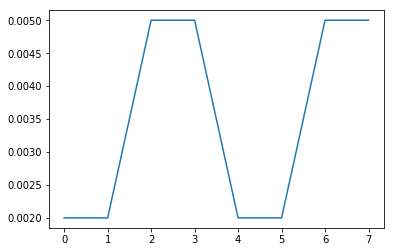

In [30]:
%matplotlib inline
# RMSE score 평가과정의 출력
results_df = pd.DataFrame.from_dict(grid_search.cv_results)
results_df.param_lr_all.plot()
# results_df.columns
#print(results_df.head(3))

<br>
### **3) Offline 에서도 활용가능한 TABLE을 생성**
Surprise 모델의 활용
1. 각 사용자에 대한 top-N 추천목록을 예측
1. 변수설정 : 
    1. predictions(예측 list) : test 모델을 사용하여 알고리즘 생성
    1. n(int) : 개별 사용자별 추천목록 수
1. 결과 값 :
    1. keys 는 사용자_id, value 는 추천 lists of tuples을 출력한다
    1. ex) [ (raw item id, rating estimation), ...] of size n.

In [31]:
from collections import defaultdict
from surprise import SVD, Dataset

def get_top_n(predictions, n=10):
    top_n = defaultdict(list)  # 추천결과 목록을 생성
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # k만큼 결과값의 순위를 나눈다
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

# SVD 알고리즘 적용
data        = Dataset.load_builtin('ml-100k')
trainset    = data.build_full_trainset()
algo        = SVD()
algo.fit(trainset)
testset     = trainset.build_anti_testset()
predictions = algo.test(testset)
print("model is comleted")

model is comleted


In [32]:
# 추천모델 예측하기
i, count, no = 0, 10, 5   # count : user 수 , no : item 수 
top_n        = get_top_n(predictions, no)
for uid, user_ratings in top_n.items():
    i += 1
    if i < count : print(uid, [iid for (iid, _) in user_ratings])

196 ['64', '56', '12', '483', '169']
186 ['185', '313', '498', '483', '427']
22 ['169', '135', '963', '707', '12']
244 ['478', '269', '483', '285', '603']
166 ['603', '136', '173', '12', '22']
298 ['169', '64', '408', '114', '136']
115 ['135', '285', '474', '134', '179']
253 ['313', '272', '651', '28', '515']
305 ['657', '515', '513', '496', '519']


In [33]:
# 추천모델 평가하기
import surprise
from surprise import Dataset
data = Dataset.load_builtin('ml-100k')
data.split(n_folds=3)

# 'name' : msd', 'cosine', 'pearson', 'pearson_baseline'
sim_options = {'name': 'pearson'}
#algo = surprise.SVD()
algo = surprise.KNNBasic(sim_options=sim_options)
surprise.model_selection.cross_validate(algo, data)
#surprise.evaluate(algo, data)

Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


{'fit_time': (2.437927722930908,
  2.497819185256958,
  2.494748115539551,
  2.374987840652466,
  1.3466737270355225),
 'test_mae': array([0.80682835, 0.80165871, 0.80448912, 0.80306221, 0.80226739]),
 'test_rmse': array([1.0128108 , 1.00681074, 1.01670642, 1.01601973, 1.00941374]),
 'test_time': (4.991057634353638,
  4.631971120834351,
  4.208972692489624,
  4.212818145751953,
  2.358833074569702)}

<br>
## **8 Accuracy 의 정확도(Precision), 재현율(Recall)과 참고사항**
1. **정확도(Precision : TP / TP + FP)** : 검색 결과로 가져온 문서 중 실제 관련된 문서 비율
1. **재현율(Recall : TP / TP + FN)** : 관련 문서 중 검색된 문서 비율
1. **TP(True Positive)** 는 추천된 항목이 사용자가 선호하는 항목인 개수
1. **FP(False Positive)** 는 추천된 항목이 사용자가 선호하지 않는 항목인 개수
1. **FN(False Negative)** 은 추천되지 않았지만 사용자가 선호하는 항목인 개수
1. **TN(True Negative)** 은 추천되지 않은 아이템이 사용자가 선호하지 않는 항목인 개수

In [34]:
# import pandas
# import numpy
# import scipy.sparse
# import scipy.sparse.linalg
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_absolute_error

# data_dir = "03_data/ml-100k/"
# data_shape = (943, 1682)
# data = surprise.Dataset.load_builtin('ml-100k')
# df   = pd.DataFrame(data.raw_ratings, 
#                     columns = ["user", "item", "rate", "id"])
# del df["id"]

In [35]:
# values = df.values
# values[:, 0:2] -= 1
# X_train = scipy.sparse.csr_matrix((values[:, 2], (values[:, 0], values[:, 1])), dtype=numpy.float, shape=data_shape)

# df = pandas.read_csv(data_dir + "ua.test", sep="\t", header=-1)
# values = df.values
# values[:, 0:2] -= 1
# X_test = scipy.sparse.csr_matrix((values[:, 2], (values[:, 0], values[:, 1])), dtype=numpy.float, shape=data_shape)

# # Compute means of nonzero elements
# X_row_mean = numpy.zeros(data_shape[0])
# X_row_sum = numpy.zeros(data_shape[0])

# train_rows, train_cols = X_train.nonzero()

# # Iterate through nonzero elements to compute sums and counts of rows elements
# for i in range(train_rows.shape[0]):
#     X_row_mean[train_rows[i]] += X_train[train_rows[i], train_cols[i]]
#     X_row_sum[train_rows[i]] += 1

# # Note that (X_row_sum == 0) is required to prevent divide by zero
# X_row_mean /= X_row_sum + (X_row_sum == 0)

# # Subtract mean rating for each user
# for i in range(train_rows.shape[0]):
#     X_train[train_rows[i], train_cols[i]] -= X_row_mean[train_rows[i]]

# test_rows, test_cols = X_test.nonzero()
# for i in range(test_rows.shape[0]):
#     X_test[test_rows[i], test_cols[i]] -= X_row_mean[test_rows[i]]

# X_train = numpy.array(X_train.toarray())
# X_test = numpy.array(X_test.toarray())

# ks = numpy.arange(2, 50)
# train_mae = numpy.zeros(ks.shape[0])
# test_mae = numpy.zeros(ks.shape[0])
# train_scores = X_train[(train_rows, train_cols)]
# test_scores = X_test[(test_rows, test_cols)]

# # Now take SVD of X_train
# U, s, Vt = numpy.linalg.svd(X_train, full_matrices=False)

# for j, k in enumerate(ks):
#     X_pred = U[:, 0:k].dot(numpy.diag(s[0:k])).dot(Vt[0:k, :])

#     pred_train_scores = X_pred[(train_rows, train_cols)]
#     pred_test_scores = X_pred[(test_rows, test_cols)]

#     train_mae[j] = mean_absolute_error(train_scores, pred_train_scores)
#     test_mae[j] = mean_absolute_error(test_scores, pred_test_scores)

#     print(k,  train_mae[j], test_mae[j])

# plt.plot(ks, train_mae, 'k', label="Train")
# plt.plot(ks, test_mae, 'r', label="Test")
# plt.xlabel("k")
# plt.ylabel("MAE")
# plt.legend()
# plt.show()